# Plots

### TODO (from old notes)
* More data?, 
* Remove arabic/roman numerals
* Qualitative interpretation, most important ngrams for different dating tasks, largest differance etc
* Visualizations, t-SNE, KernelPCA, animation?
* Evaluate as graph with affinity kernel
* n-top accuracy
* Classify to bins
* Investigate why spark is so slow


In [1]:
import os
import os.path
import numpy as np
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#import ipympl

%matplotlib inline
#%matplotlib widget

In [6]:
def load_dataset(data_source_filename):
    print("Loading %s... " % data_source_filename.split("/")[-1], end="")
    t = time.time()
    dataset = dict()
    with np.load(data_source_filename, allow_pickle=True) as source_file:
        for key in source_file.keys():
            # print(key)
            dataset[key] = source_file[key].tolist()
    print("done (%.1fs)" % (time.time()-t), flush=True)
    return dataset

data_source_filenames = [os.path.join('data', fn) for fn in os.listdir('data')
                            if os.path.isfile(os.path.join('data', fn)) and fn[-3:]=='npz']
data_source_filenames

['data/StClare_facs_danish.npz',
 'data/SDHK_Latin.npz',
 'data/StClare_facs_latin.npz',
 'data/StClare_dipl_danish.npz',
 'data/StClare_dipl_latin.npz',
 'data/SDHK_Swedish.npz',
 'data/Colonia.npz',
 'data/SemEval2015.npz']

## Histogram over years

In [8]:
years = dict()
for data_source_filename in data_source_filenames:
    dataset = load_dataset(data_source_filename)
    k = data_source_filename.split("/")[-1].split(".")[0]
    years[k] = np.asarray([np.mean(item['date']) if type(item['date']) is tuple else item['date'] for item in dataset['data']])

Loading StClare_facs_danish.npz... done (0.2s)
Loading SDHK_Latin.npz... done (1.5s)
Loading StClare_facs_latin.npz... done (0.1s)
Loading StClare_dipl_danish.npz... done (0.0s)
Loading StClare_dipl_latin.npz... done (0.1s)
Loading SDHK_Swedish.npz... done (0.6s)
Loading Colonia.npz... done (5.5s)
Loading SemEval2015.npz... done (0.2s)


/home/fredrik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


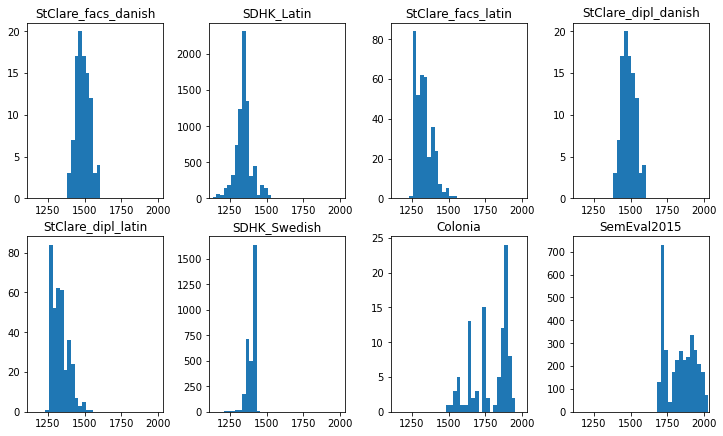

In [9]:
import matplotlib.pyplot as plt

y_min = np.inf
y_max = -np.inf
for k in years.keys():
    y_min = min(y_min, years[k].min())
    y_max = max(y_max, years[k].max())

bin_width = 25
y_min = int(bin_width*y_min//bin_width)
y_max = int(bin_width*y_max//bin_width + bin_width)

fig = plt.figure(figsize=(10, 6))
axes = fig.subplots(2, int(np.ceil(len(data_source_filenames)/2))).ravel()

for axis, k in zip(axes, years.keys()):
    axis.set_title("%s" % k)
    axis.hist(years[k], list(range(y_min, y_max, bin_width)))

    a = list(axis.axis())
    a[0] = y_min
    a[1] = y_max
    axis.axis(a)

fig.tight_layout(pad=.5)
fig.show()

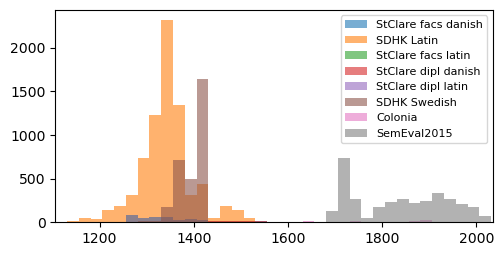

In [10]:
plt.figure(figsize=(5, 2.5), dpi=100)
plt.set_cmap('Pastel1')

for i, k in enumerate(years.keys()):
    plt.hist(years[k], list(range(y_min, y_max, bin_width)), density=False, 
             label="%s" % k.replace("_", " "), alpha=.6, color='C%i' % i)

# plt.yticks([])
#plt.yscale('log')

a = list(plt.axis())
a[0] = y_min
a[1] = y_max
plt.axis(a)
plt.legend(fontsize=8)
plt.tight_layout(pad=.5)
plt.savefig("plots/collection_years_hist.svg", format="svg")
plt.show()

In [11]:
y_min, y_max = 1100, 2050

No handles with labels found to put in legend.


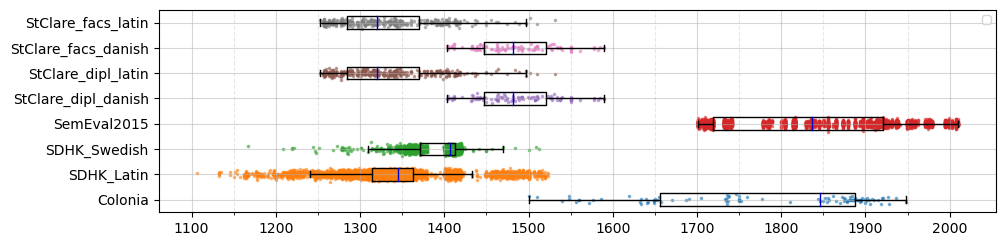

In [14]:
ngroup = len(years.keys())
n = 2
fig, ax = plt.subplots(figsize=(5*n, 1.2*n), dpi=100)

#plt.boxplot([bin_width*(years[k]//bin_width) for i,k in enumerate(sorted(years.keys()))], flierprops=flierprops, labels=sorted(years.keys()), vert=False)
plt.boxplot([years[k] for i,k in enumerate(sorted(years.keys()))],
            labels=sorted(years.keys()),
            vert=False,
            showfliers=False,
            medianprops={"c":"mediumblue"})

for i, k in enumerate(sorted(years.keys())):
    plt.scatter(years[k], np.random.normal(i+1, 0.08, len(years[k])), alpha=0.5, s=10, marker=".")

# Major ticks every 20, minor ticks every 5
major_ticks = list(range(y_min, y_max, 100))
minor_ticks = list(range(y_min, y_max, 50))

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.grid(which='minor', axis="x", alpha=0.3, linestyle='--')
ax.grid(which='major', axis="both", alpha=0.5, linestyle='-')

plt.legend(fontsize=8)
plt.tight_layout(pad=.5)
plt.savefig("plots/collection_years_box.svg", format="svg")

## PCA of something

In [16]:
print(data_source_filenames)
data_source_filename = data_source_filenames[0]
dataset = load_dataset(data_source_filename)
print("Feature sets:", dataset['feature_sets'].keys())

['data/SDHK_Latin.npz', 'data/velux_facs_danish.npz', 'data/SDHK_Swedish.npz', 'data/Colonia.npz', 'data/SemEval2015.npz', 'data/velux_dipl_latin.npz', 'data/velux_facs_latin.npz', 'data/velux_dipl_danish.npz']
Loading SDHK_Latin.npz... done (1.7s)
Feature sets: dict_keys(['bow_words', 'tfidf_words', 'character_ngram_1', 'character_ngram_2', 'character_ngram_3', 'word_ngram_1', 'word_ngram_2', 'word_ngram_3'])


In [17]:
y = np.asarray([np.mean(item['date']) if type(item['date']) is tuple else item['date'] for item in dataset['data']])
X = dataset['feature_sets']['character_ngram_3']

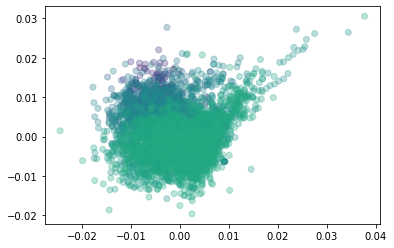

In [18]:
from sklearn.decomposition import PCA

model = PCA(n_components=4)
X = X.todense()
X_pca = model.fit_transform(X)

n=5000
plt.figure()
plt.scatter(X_pca[:n, 1], X_pca[:n, 3], c=y[:n], alpha=.3, cmap='viridis')
plt.show()

/home/fredrik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


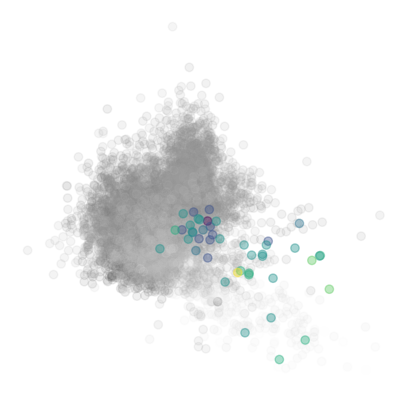

In [19]:
import matplotlib.pyplot as plt

base_year= 1500
window = 5
m = np.logical_and(base_year-window < y, y < base_year+window)
# m = m[:1000]
fig = plt.figure(figsize=(5, 5), dpi=100)
ax = fig.subplots(1, 1)
ax.scatter(X_pca[np.invert(m), 1], X_pca[np.invert(m), 0], c=y[np.invert(m)], alpha=.1, cmap='gray')
ax.scatter(X_pca[m, 1], X_pca[m, 3], c=y[m], alpha=.4, cmap='viridis')
ax.axis('off')
fig.show()

/home/fredrik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


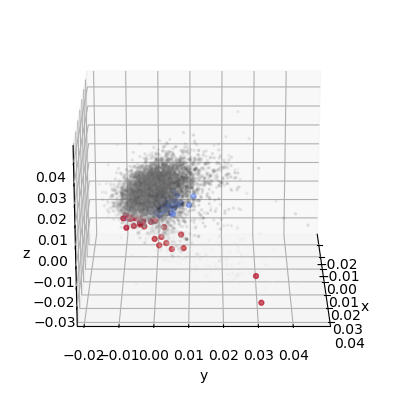

In [20]:
fig = plt.figure(figsize=(8, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1, projection='3d')

base_year= 1300
window = 10
mask = np.logical_and(base_year-window < y, y < base_year+window)

mask = np.logical_or(1510 < y, y < 1200)

points = ax.scatter(X_pca[np.invert(mask), 1], X_pca[np.invert(mask), 2], X_pca[np.invert(mask), 0], c=y[np.invert(mask)], alpha=.1, cmap='gray', marker='.', s=10)
f = ax.scatter(X_pca[mask, 1], X_pca[mask, 2], X_pca[mask, 0], c=y[mask], alpha=.7, cmap='coolwarm', marker='.', s=50)
ax.view_init(20, 0)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
# ax.set_xlim(-.03,.03)
# ax.set_ylim(-.03,.03)
# ax.set_zlim(-.03,.03)
fig.show()



100%|██████████| 360/360 [01:11<00:00,  5.05it/s]


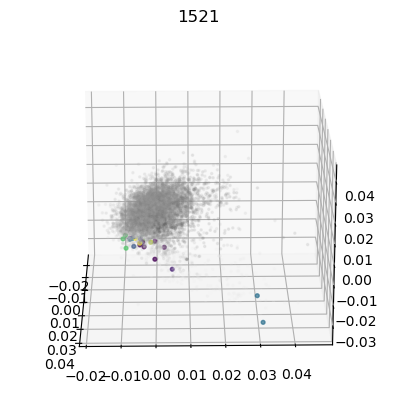

In [23]:
n_frames = 360

time_frame = [np.min(y), np.max(y)]

def get_mask(base_year, window = 10):
  return np.logical_and(base_year-window < y, y < base_year+window)

fig = plt.figure(figsize=(8, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter(X_pca[np.invert(m), 1], X_pca[np.invert(m), 2], X_pca[np.invert(m), 0], c=y[np.invert(m)], alpha=.1, cmap='gray', marker='.', s=10)
ax.scatter(X_pca[m, 1], X_pca[m, 2], X_pca[m, 0], c=y[m], alpha=.7, cmap='viridis', marker='.', s=50)

def init():
    ax.view_init(20, 0)
    return fig,

def update(frame):
  # Define foreground
  Y = int(time_frame[0]+frame*(time_frame[1]-time_frame[0])/n_frames)
  ax.set_title("%i" % Y)
  mask = get_mask(Y)
  # Clear plot
  ax.collections = []
  # Plot points
  ax.scatter(X_pca[np.invert(mask), 1], X_pca[np.invert(mask), 2], X_pca[np.invert(mask), 0], c=y[np.invert(mask)], alpha=.1, cmap='gray', marker='.', s=10)
  ax.scatter(X_pca[mask, 1], X_pca[mask, 2], X_pca[mask, 0], c=y[mask], alpha=.7, cmap='viridis', marker='.', s=30)
  # Setting scale
  # ax.set_xlim(-.03,.03)
  # ax.set_ylim(-.03,.03)
  # ax.set_zlim(-.03,.03)
  # Rotation
  angle = frame % 360
  ax.view_init(20, angle)
  return fig,

fps = 10
anim = FuncAnimation(fig, update, frames=tqdm(range(n_frames), initial=1, position=0), interval=1000/fps, init_func=init, blit=True)
# anim = FuncAnimation(fig, update, frames=range(n_frames), interval=1000/fps, init_func=init, blit=True)
#anim.save('cloud_pca.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
#HTML(anim.to_html5_video())
anim.save('cloud_pca.gif', writer='ffmpeg')

In [25]:
from MulticoreTSNE import MulticoreTSNE as TSNE
tsne_model = TSNE(n_components=3, n_jobs=os.cpu_count()-1)
X_tsne = tsne_model.fit_transform(X)

/home/fredrik/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


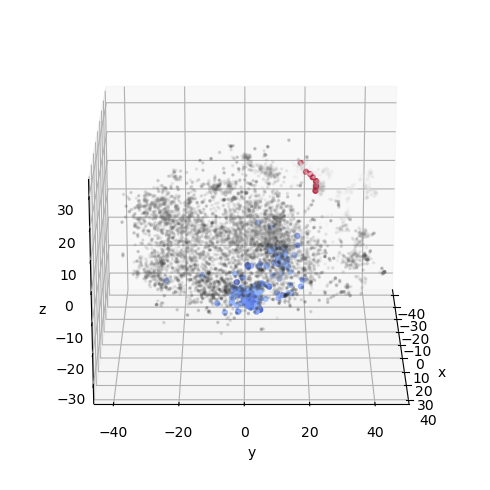

In [26]:
fig = plt.figure(figsize=(8, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1, projection='3d')

# base_year= 1400
# window = 25
# mask = np.logical_and(base_year-window < y, y < base_year+window)

mask = np.logical_or(1518 < y, y < 1220)

points = ax.scatter(X_tsne[np.invert(mask), 1], X_tsne[np.invert(mask), 2], X_tsne[np.invert(mask), 0], c=y[np.invert(mask)], alpha=.1, cmap='gray', marker='.', s=10)
f = ax.scatter(X_tsne[mask, 1], X_tsne[mask, 2], X_tsne[mask, 0], c=y[mask], alpha=.7, cmap='coolwarm', marker='.', s=50)
ax.view_init(20, 0)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
# ax.set_xlim(-.03,.03)
# ax.set_ylim(-.03,.03)
# ax.set_zlim(-.03,.03)
fig.tight_layout()
fig.show()



Rendering animation: 100%|██████████| 360/360 [01:10<00:00,  5.07it/s]


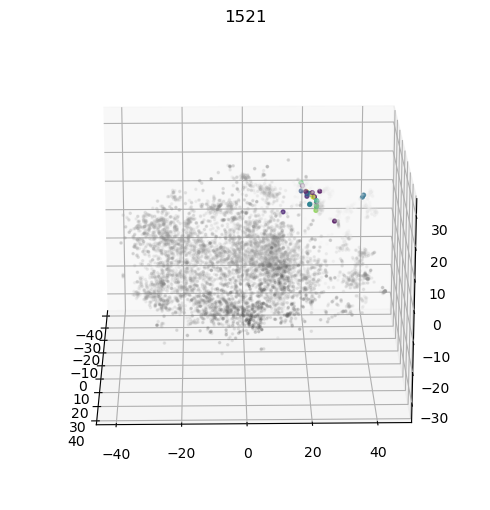

In [27]:
n_frames = 360

time_frame = [np.min(y), np.max(y)]

def get_mask(base_year, window = 10):
    return np.logical_and(base_year-window < y, y < base_year+window)

fig = plt.figure(figsize=(8, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1, projection='3d')

ax.scatter(X_tsne[np.invert(m), 1], X_tsne[np.invert(m), 2], X_tsne[np.invert(m), 0], c=y[np.invert(m)], alpha=.1, cmap='gray', marker='.', s=10)
ax.scatter(X_tsne[m, 1], X_tsne[m, 2], X_tsne[m, 0], c=y[m], alpha=.7, cmap='viridis', marker='.', s=50)
fig.tight_layout()

def init():
    ax.view_init(20, 0)
    return fig,

def update(frame):
    # Define foreground
    Y = int(time_frame[0]+frame*(time_frame[1]-time_frame[0])/n_frames)
    ax.set_title("%i" % Y)
    mask = get_mask(Y)
    #mask = np.logical_or(1518 < y, y < 1220)
    # Clear plot
    ax.collections = []
    # Plot points
    ax.scatter(X_tsne[np.invert(mask), 1], X_tsne[np.invert(mask), 2], X_tsne[np.invert(mask), 0], c=y[np.invert(mask)], alpha=.1, cmap='gray', marker='.', s=10)
    ax.scatter(X_tsne[mask, 1], X_tsne[mask, 2], X_tsne[mask, 0], c=y[mask], alpha=.7, cmap='viridis', marker='.', s=30)
    # Setting scale
    # ax.set_xlim(-.03,.03)
    # ax.set_ylim(-.03,.03)
    # ax.set_zlim(-.03,.03)
    # Rotation
    angle = frame % 360
    ax.view_init(20, angle)
    return fig,

fps = 10
anim = FuncAnimation(fig, update, 
                     frames=tqdm(range(n_frames), initial=1, position=0, 
                                 total=n_frames, desc="Rendering animation"), 
                     interval=1000/fps, init_func=init, blit=True)
# anim = FuncAnimation(fig, update, frames=range(n_frames), interval=1000/fps, init_func=init, blit=True)
#anim.save('cloud_tsne.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
#HTML(anim.to_html5_video())
anim.save('cloud_tsne.gif', writer='ffmpeg')